# CIFAR dataset

Set seeds, import data, define some functions

In [1]:
import os
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import warnings

seed = 4398

os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

np.set_printoptions(suppress=True)

cifar = tf.keras.datasets.cifar10.load_data()

(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar
input_shape_cifar = (32, 32, 3)
num_classes = 10

x_train_cifar = x_train_cifar.astype("float32") / 255
x_test_cifar = x_test_cifar.astype("float32") / 255
x_train_cifar = np.expand_dims(x_train_cifar, -1)
x_test_cifar = np.expand_dims(x_test_cifar, -1)

y_train_cifar = keras.utils.to_categorical(y_train_cifar, num_classes)
y_test_cifar = keras.utils.to_categorical(y_test_cifar, num_classes)

def create_cifar_model(activation="softmax", input_shape=(32, 32, 3)):
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dense(10, activation=activation))

  return model

def build_and_evaluate_model(activation, loss, epochs=5, verbose=False, batch_size=128):
  model = create_cifar_model(activation=activation)

  model.compile(loss=loss, optimizer="adam", metrics=["accuracy"])

  model.fit(x_train_cifar, y_train_cifar, batch_size=batch_size, epochs=epochs, validation_split=0.1)
  test_preds = model.predict(x_test_cifar, verbose=1)

  test_scores = model.evaluate(x_test_cifar, y_test_cifar, verbose=1)
  if verbose:
    model.summary()
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])

  return model, test_scores, test_preds

def within_epsilon(expected, value, epsilon=0.0001):
  return abs(test['expected'] - loss) <= epsilon

170498071/170498071 [==============================] - 4s 0us/step


### Normal cross entropy code

Copying cross entropy code from keras so I can replicate it and (later) change it

In [2]:
def _get_logits(output, from_logits, op_type, fn_name):
    output_ = output
    from_logits_ = from_logits

    has_keras_logits = hasattr(output, "_keras_logits")
    if has_keras_logits:
        output_ = output._keras_logits
        from_logits_ = True

    from_expected_op_type = (
        not isinstance(output, (tf.__internal__.EagerTensor, tf.Variable))
        and output.op.type == op_type
    ) and not has_keras_logits

    if from_expected_op_type:
        # When softmax activation function is used for output operation, we
        # use logits from the softmax function directly to compute loss in order
        # to prevent collapsing zero when training.
        # See b/117284466
        assert len(output.op.inputs) == 1
        output_ = output.op.inputs[0]
        from_logits_ = True

    if from_logits and (has_keras_logits or from_expected_op_type):
        warnings.warn(
            f'"`{fn_name}` received `from_logits=True`, but '
            f"the `output` argument was produced by a {op_type} "
            "activation and thus does not represent logits. "
            "Was this intended?",
            stacklevel=2,
        )

    return output_, from_logits_

def backend_ce(target, output, from_logits=False, axis=-1):
    target = tf.convert_to_tensor(target)
    output = tf.convert_to_tensor(output)
    target.shape.assert_is_compatible_with(output.shape)

    output, from_logits = _get_logits(
        output, from_logits, "Softmax", "categorical_crossentropy"
    )
    if from_logits:
        return tf.nn.softmax_cross_entropy_with_logits(
            labels=target, logits=output, axis=axis
        )

    # scale preds so that the class probas of each sample sum to 1
    output = output / tf.reduce_sum(output, axis, True)
    # Compute cross entropy from probabilities.
    epsilon_ = keras.backend._constant_to_tensor(keras.backend.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, epsilon_, 1.0 - epsilon_)
    return -tf.reduce_sum(target * tf.math.log(output), axis)

def keras_categorical_crossentropy(
    y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1
):
  y_pred = tf.convert_to_tensor(y_pred)
  y_true = tf.cast(y_true, y_pred.dtype)
  label_smoothing = tf.convert_to_tensor(label_smoothing, dtype=y_pred.dtype)

  def _smooth_labels():
      num_classes = tf.cast(tf.shape(y_true)[-1], y_pred.dtype)
      return y_true * (1.0 - label_smoothing) + (
          label_smoothing / num_classes
      )

  y_true = tf.__internal__.smart_cond.smart_cond(
      label_smoothing, _smooth_labels, lambda: y_true
  )

  return backend_ce(
      y_true, y_pred, from_logits=from_logits, axis=axis
  )

### Uniform prediction prior 

Update cross entropy code to prefer equal predictions on negative classes

In [3]:
def backend_ce_custom(target, output, from_logits=False, axis=-1, custom_version=1):
    target = tf.convert_to_tensor(target)
    output = tf.convert_to_tensor(output)
    target.shape.assert_is_compatible_with(output.shape)

    output, from_logits = _get_logits(
        output, from_logits, "Softmax", "categorical_crossentropy"
    )
    #if from_logits:
    #    return tf.nn.softmax_cross_entropy_with_logits(
    #        labels=target, logits=output, axis=axis
    #    )

    # scale preds so that the class probas of each sample sum to 1
    output = output / tf.reduce_sum(output, axis, True)
    # Compute cross entropy from probabilities.
    epsilon_ = keras.backend._constant_to_tensor(keras.backend.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, epsilon_, 1.0 - epsilon_)

    # Custom code here
    inverse_mask = tf.ones_like(target) - target
    pred_of_positive = tf.reduce_sum(tf.math.multiply(target, output))
    remainder = tf.constant(1.) - pred_of_positive
    # Uniform prediction prior among the negative classes
    expected = remainder / tf.cast((len(target) - 1), tf.float32)

    if custom_version == 1:
      log_losses_negative = tf.reduce_sum(tf.math.multiply(inverse_mask, tf.math.abs(output - expected)))
    elif custom_version == 2:
      log_losses_negative = -tf.reduce_sum(tf.math.multiply(inverse_mask, tf.math.log(1 - tf.math.abs(output - expected))))
    elif custom_version == 3:
      log_losses_negative = tf.reduce_sum(tf.math.multiply(inverse_mask, 10*tf.math.abs(output - expected)))

    log_losses_positive = -tf.reduce_sum(target * tf.math.log(output), axis)

    return tf.math.add(log_losses_positive, log_losses_negative)

def keras_categorical_crossentropy_custom_abs(
    y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1
):
  y_pred = tf.convert_to_tensor(y_pred)
  y_true = tf.cast(y_true, y_pred.dtype)
  label_smoothing = tf.convert_to_tensor(label_smoothing, dtype=y_pred.dtype)

  def _smooth_labels():
      num_classes = tf.cast(tf.shape(y_true)[-1], y_pred.dtype)
      return y_true * (1.0 - label_smoothing) + (
          label_smoothing / num_classes
      )

  y_true = tf.__internal__.smart_cond.smart_cond(
      label_smoothing, _smooth_labels, lambda: y_true
  )

  return backend_ce_custom(
      y_true, y_pred, from_logits=from_logits, axis=axis
  )

def keras_categorical_crossentropy_custom_log(
    y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1
):
  y_pred = tf.convert_to_tensor(y_pred)
  y_true = tf.cast(y_true, y_pred.dtype)
  label_smoothing = tf.convert_to_tensor(label_smoothing, dtype=y_pred.dtype)

  def _smooth_labels():
      num_classes = tf.cast(tf.shape(y_true)[-1], y_pred.dtype)
      return y_true * (1.0 - label_smoothing) + (
          label_smoothing / num_classes
      )

  y_true = tf.__internal__.smart_cond.smart_cond(
      label_smoothing, _smooth_labels, lambda: y_true
  )

  return backend_ce_custom(
      y_true, y_pred, from_logits=from_logits, axis=axis, custom_version=2
  )


def keras_categorical_crossentropy_custom_dramatic(
    y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1
):
  y_pred = tf.convert_to_tensor(y_pred)
  y_true = tf.cast(y_true, y_pred.dtype)
  label_smoothing = tf.convert_to_tensor(label_smoothing, dtype=y_pred.dtype)

  def _smooth_labels():
      num_classes = tf.cast(tf.shape(y_true)[-1], y_pred.dtype)
      return y_true * (1.0 - label_smoothing) + (
          label_smoothing / num_classes
      )

  y_true = tf.__internal__.smart_cond.smart_cond(
      label_smoothing, _smooth_labels, lambda: y_true
  )

  return backend_ce_custom(
      y_true, y_pred, from_logits=from_logits, axis=axis, custom_version=3
  )

In [4]:
# Example of using a custom loss function

keras_categorical_crossentropy_custom_abs([0, 0, 1], [0.3, 0.1, 0.6])

<tf.Tensor: shape=(), dtype=float32, numpy=0.71082556>

In [5]:
loss_tests_log = [
    {
        'expected': -np.log(0.6),
        'y_true': [0, 0, 1],
        'y_pred': [0.2, 0.2, 0.6]
    },
    {
        'expected': -(np.log(0.6) + np.log(0.9) + np.log(0.9)),
        'y_true': [0, 0, 1],
        'y_pred': [0.3, 0.1, 0.6]
    },
    {
        'expected': -(np.log(0.6) + np.log(0.9) + np.log(0.95) + np.log(0.95)),
        'y_true': [0, 0, 1, 0, 0],
        'y_pred': [0.2, 0.05, 0.6, 0.05, 0.1]
    },
]

for i, test in enumerate(loss_tests_log):
  loss = keras_categorical_crossentropy_custom_log(test['y_true'], test['y_pred'])
  if not within_epsilon(test['expected'], loss):
    print(f"Failed test {i} (log), expected {test['expected']}, got {loss}")

loss_tests_abs = [
    {
        'expected': -np.log(0.6),
        'y_true': [0, 0, 1],
        'y_pred': [0.2, 0.2, 0.6]
    },
    {
        'expected': -np.log(0.6) + 0.1 + 0.1,
        'y_true': [0, 0, 1],
        'y_pred': [0.3, 0.1, 0.6]
    },
    {
        'expected': -np.log(0.6) + 0.1 + 0.05 + 0.05,
        'y_true': [0, 0, 1, 0, 0],
        'y_pred': [0.2, 0.05, 0.6, 0.05, 0.1]
    },
]

for i, test in enumerate(loss_tests_abs):
  loss = keras_categorical_crossentropy_custom_abs(test['y_true'], test['y_pred'])
  if not within_epsilon(test['expected'], loss):
    print(f"Failed test {i} (abs), expected {test['expected']}, got {loss}")

print("Tests finished")

Tests finished


## Run experiments

In [6]:
%%time

epochs = 10

specifications = [
    {
        'name': 'Traditional',
        'loss': "categorical_crossentropy",
        'epochs': epochs,
        'activation': 'softmax',
    },
    {
        'name': 'Traditional with BCE',
        'loss': "binary_crossentropy",
        'epochs': epochs,
        'activation': 'sigmoid',
    },
    {
        'name': 'Replicated CE',
        'loss': keras_categorical_crossentropy,
        'epochs': epochs,
        'activation': 'softmax',
    },
    {
        'name': 'CE with abs uniform prediction prior',
        'loss': keras_categorical_crossentropy_custom_abs,
        'epochs': epochs,
        'activation': 'softmax',
    },
    {
        'name': 'CE with log uniform prediction prior',
        'loss': keras_categorical_crossentropy_custom_log,
        'epochs': epochs,
        'activation': 'softmax',
    },
    {
        'name': 'CE with strong uniform prediction prior',
        'loss': keras_categorical_crossentropy_custom_dramatic,
        'epochs': epochs,
        'activation': 'softmax',
    },
]

results = {}

for experiment in specifications:
   print(f"Training model \"{experiment['name']}\"")
   (model, test_scores, test_preds) = build_and_evaluate_model(
       experiment['activation'], experiment['loss'], experiment['epochs'])
   results[experiment['name']] = {'model': model, 'test_scores': test_scores, 'test_preds': test_preds}

for experiment in results:
  test_accuracy = results[experiment]['test_scores'][1]
  print(f"{experiment}: test accuracy of {test_accuracy}")

Training model "Traditional"
Epoch 1/10
352/352 [==============================] - 61s 169ms/step - loss: 1.5517 - accuracy: 0.4446 - val_loss: 1.2687 - val_accuracy: 0.5522
Epoch 2/10
352/352 [==============================] - 59s 168ms/step - loss: 1.1829 - accuracy: 0.5847 - val_loss: 1.1026 - val_accuracy: 0.6172
Epoch 3/10
352/352 [==============================] - 59s 167ms/step - loss: 1.0291 - accuracy: 0.6387 - val_loss: 1.0249 - val_accuracy: 0.6372
Epoch 4/10
352/352 [==============================] - 60s 170ms/step - loss: 0.9412 - accuracy: 0.6719 - val_loss: 0.9757 - val_accuracy: 0.6590
Epoch 5/10
352/352 [==============================] - 59s 167ms/step - loss: 0.8703 - accuracy: 0.6973 - val_loss: 0.9130 - val_accuracy: 0.6864
Epoch 6/10
352/352 [==============================] - 59s 167ms/step - loss: 0.8135 - accuracy: 0.7168 - val_loss: 0.8732 - val_accuracy: 0.7002
Epoch 7/10
352/352 [==============================] - 60s 169ms/step - loss: 0.7640 - accuracy: 0.733

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


352/352 [==============================] - 58s 162ms/step - loss: 1.6185 - accuracy: 0.4214 - val_loss: 1.3104 - val_accuracy: 0.5416
Epoch 2/10
352/352 [==============================] - 58s 164ms/step - loss: 1.2178 - accuracy: 0.5672 - val_loss: 1.1628 - val_accuracy: 0.6000
Epoch 3/10
352/352 [==============================] - 58s 164ms/step - loss: 1.0476 - accuracy: 0.6318 - val_loss: 1.0229 - val_accuracy: 0.6366
Epoch 4/10
352/352 [==============================] - 58s 165ms/step - loss: 0.9534 - accuracy: 0.6660 - val_loss: 0.9626 - val_accuracy: 0.6598
Epoch 5/10
352/352 [==============================] - 60s 170ms/step - loss: 0.8810 - accuracy: 0.6920 - val_loss: 0.9102 - val_accuracy: 0.6864
Epoch 6/10
352/352 [==============================] - 57s 163ms/step - loss: 0.8185 - accuracy: 0.7134 - val_loss: 0.9027 - val_accuracy: 0.6934
Epoch 7/10
352/352 [==============================] - 61s 174ms/step - loss: 0.7768 - accuracy: 0.7295 - val_loss: 0.8785 - val_accuracy: 0.7

### Output some statistics about the various predictions

Mean prediction for incorrect classes (base model) 0.0412888266146183
Mean prediction for incorrect classes (custom loss)) 0.09487645328044891
Std dev of predictions for incorrect classes (base model) 0.12280698865652084
Std dev of predictions for incorrect classes (custom loss)) 0.05341934412717819
Mean of row-level std deviations of predictions for incorrect classes (base model) 0.0806240513920784
Mean of row-level std deviations of predictions for incorrect classes (custom loss) 0.052581965923309326


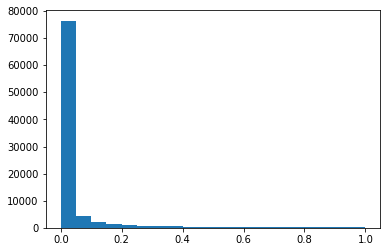

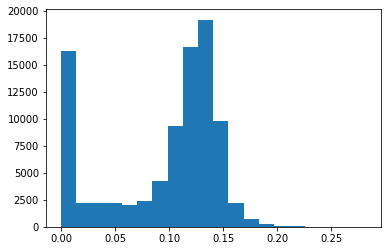

In [7]:
import matplotlib.pyplot as plt

all_incorrect_base = []
all_incorrect_custom = []

std_of_wrongs_base = []
std_of_wrongs_custom = []

preds_cifar_base = results['Replicated CE']['test_preds']
preds_cifar_custom = results['CE with strong uniform prediction prior']['test_preds']

for i in range(len(y_test_cifar)):
  local_incorrect_base = []
  local_incorrect_custom = []
  for j in range(len(preds_cifar_base[i])):
    if y_test_cifar[i][j] != 1:
      all_incorrect_base.append(preds_cifar_base[i][j])
      all_incorrect_custom.append(preds_cifar_custom[i][j])
      local_incorrect_base.append(preds_cifar_base[i][j])
      local_incorrect_custom.append(preds_cifar_custom[i][j])

  std_of_wrongs_base.append(np.std(local_incorrect_base))
  std_of_wrongs_custom.append(np.std(local_incorrect_custom))

print(f"Mean prediction for incorrect classes (base model) {np.mean(all_incorrect_base)}")
print(f"Mean prediction for incorrect classes (custom loss)) {np.mean(all_incorrect_custom)}")

print(f"Std dev of predictions for incorrect classes (base model) {np.std(all_incorrect_base)}")
print(f"Std dev of predictions for incorrect classes (custom loss)) {np.std(all_incorrect_custom)}")

print(f"Mean of row-level std deviations of predictions for incorrect classes (base model) {np.mean(std_of_wrongs_base)}")
print(f"Mean of row-level std deviations of predictions for incorrect classes (custom loss) {np.mean(std_of_wrongs_custom)}")

plt.hist(all_incorrect_base, bins=20)
plt.show()

plt.hist(all_incorrect_custom, bins=20)
plt.show()